In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
file = 'D:/data/wedling gun/E016 2021 18.csv'#10th5028096-1003_2035有缺失值，10th5495048-1004_3598有离群点
df = pd.read_csv(file, index_col='time',low_memory=False)
df.index = pd.to_datetime(df.index).tz_localize(None)
df = df.resample('S').asfreq()
df=df.apply(pd.to_numeric, errors='ignore')
df[df['in_Sheet_thickness']>5] = np.nan
df[df['in_Sheet_thickness']<=0] = np.nan

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler
list = [2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19]
df.iloc[:, list]= StandardScaler().fit_transform(df.iloc[:, list])# 数值类型特征标准化
df.iloc[:, list]= MinMaxScaler().fit_transform(df.iloc[:, list])
L = df.iloc[:, list]
L_imputed=df.iloc[:, list]
L_imputed.fillna(method='ffill', inplace=True)
L_imputed.to_csv('D:/data/paper data/L_imputed.csv')

D:\Anaconda3\envs\darts\lib\site-packages\pandas\core\frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [3]:
LEN=1200
AHEAD=60
HIS=120
LIST_TAR=[2]
LIST_COVS=[1,3,4,9,10,11,12,13,14,16]

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset
from darts.metrics import coefficient_of_variation,mae,mape,marre,mase,mse
#data_tar = L_imputed.iloc[-LEN:, LIST_TAR]
#data_covs = L_imputed.iloc[-LEN:, LIST_COVS]
data_tar = L_imputed.iloc[-LEN-650:-650, LIST_TAR]
data_covs = L_imputed.iloc[-LEN-650:-650, LIST_COVS]
series_tar = TimeSeries.from_dataframe(data_tar,freq='S').astype(np.float32)
train, test = series_tar[:-AHEAD], series_tar[-AHEAD:]
series_covs = TimeSeries.from_dataframe(data_covs,freq='S').astype(np.float32)
past_covs,future_cosv = series_covs[:-AHEAD], series_covs[-AHEAD:]

D:\Anaconda3\envs\darts\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
[2022-06-20 07:40:58,816] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags
[2022-06-20 07:40:58,816] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full sup

Epoch 99: 100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 58.77it/s, loss=0.071, train_loss=0.0705]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 31it [00:00, ?it/s]
TCNModel coefficient_of_variation: 50.62176821464694
TCNModel mae: 0.20130663
TCNModel mape: 265.58473110198975
TCNModel marre: 20.843955874443054
TCNModel mse: 0.06196718


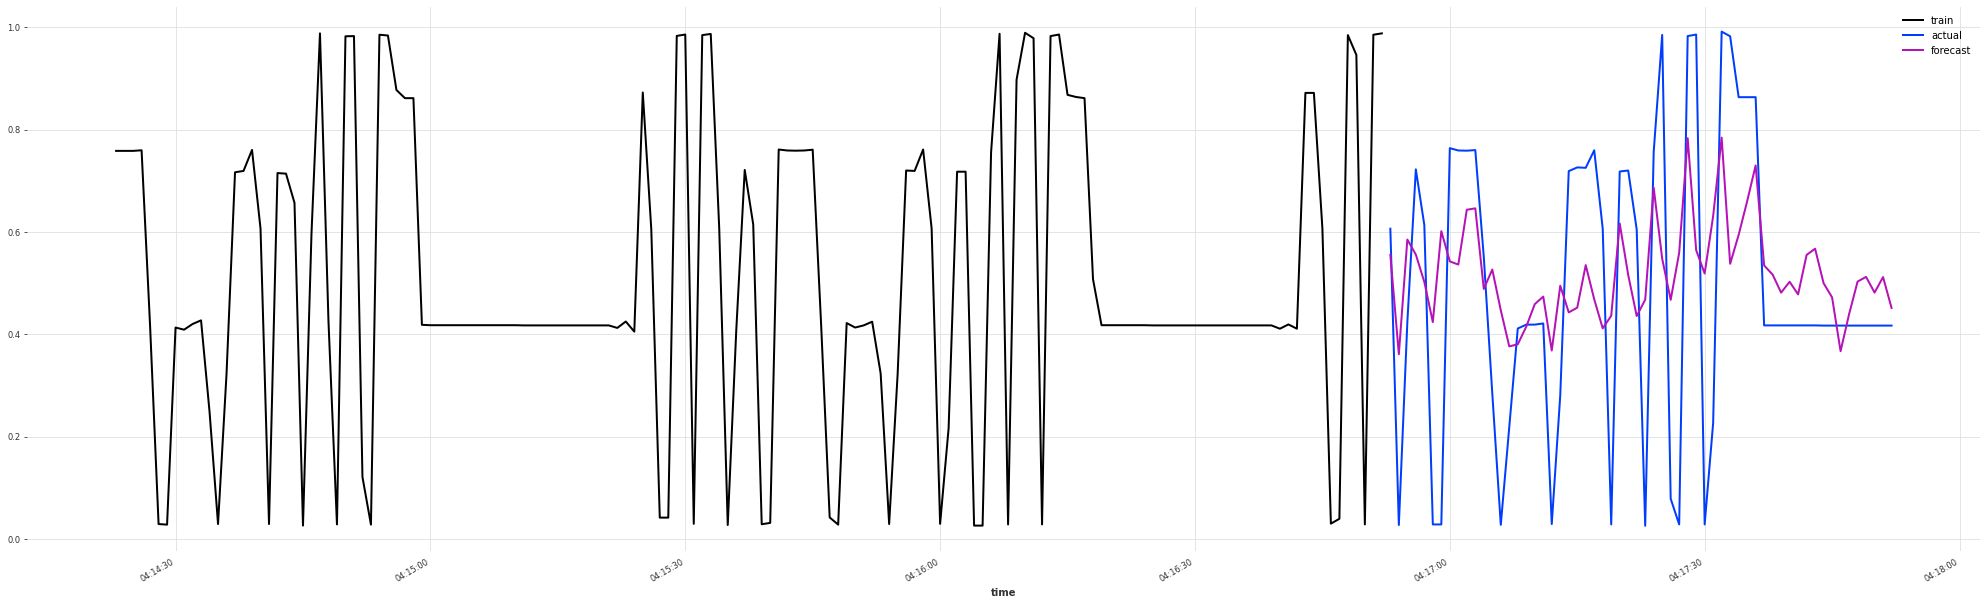

In [5]:
from darts.models import TCNModel

model_TCNModel = TCNModel(
    input_chunk_length=HIS,
    output_chunk_length=AHEAD,
    kernel_size =3,
    num_filters= 3,
    dilation_base =2,
    weight_norm = False,
    dropout = 0.2,
    torch_device_str='cuda'
    
)
model_TCNModel.fit(train,past_covariates=past_covs)
predl_TCNModel = model_TCNModel.predict(series=train,n=AHEAD,past_covariates=series_covs)

# # scale back:
# pred = scaler.inverse_transform(pred)

plt.figure(figsize=(35, 10))
train[-150:].plot(label="train")
test.plot(label="actual")
predl_TCNModel.plot(label="forecast")
print("TCNModel coefficient_of_variation:", coefficient_of_variation(test, predl_TCNModel))
print("TCNModel mae:", mae(test, predl_TCNModel))
print("TCNModel mape:", mape(test, predl_TCNModel))
print("TCNModel marre:", marre(test, predl_TCNModel))
print("TCNModel mse:", mse(test, predl_TCNModel))